In [93]:
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt
from autograd import scipy as spg
from autograd import numpy as npg



In [395]:
# Simulation 100 t-tests with 0.05
dist1 = np.random.normal(0, 1, size = (1100, 100))
dist2 = np.random.normal(0, 1, size = (1100, 100))

_, p_vals = st.ttest_ind(dist1, dist2, axis = 1)


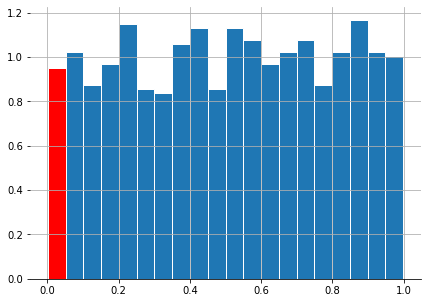

In [396]:
plt.figure(figsize=(7,5))
_, _, patches = plt.hist(p_vals, bins =20, ec ='w', density=True);
patches[0].set_fc('r')
plt.grid()
sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200410_dummy_data.png")

In [377]:
data = pd.read_csv("./prostmat.csv")

In [378]:
control_cols = [x for x in list(data.columns) if x.startswith('control')]
cancer_cols = [x for x in list(data.columns) if x.startswith('cancer')]

prostrate = data.melt(var_name = 'arm')
prostrate['patient_id'] = prostrate.arm.str.extract(r".([0-9]*)$")
prostrate['arm_type'] = prostrate.arm.str.extract(r"^([a-z]*).?[0-9]*$")

In [379]:
prostrate.loc[prostrate["patient_id"] == "", "patient_id"] = "0"
prostrate['gene'] = prostrate.groupby(['arm','patient_id'])['value'].cumcount()

In [380]:
ttest_res = dict()
p_val = dict()
for gene, df in prostrate.groupby('gene'):
    ttest_res[gene], p_val[gene] = st.ttest_ind(df.loc[df.arm_type == 'control', 'value'], df.loc[df.arm_type == 'cancer', 'value'])

In [381]:
trans_t = st.norm.ppf(st.t(df = 100).cdf(list(ttest_res.values())))

In [382]:
trans_t

array([-1.46953732, -3.55222426,  0.02766708, ...,  1.18812022,
       -0.1034607 ,  0.91200949])

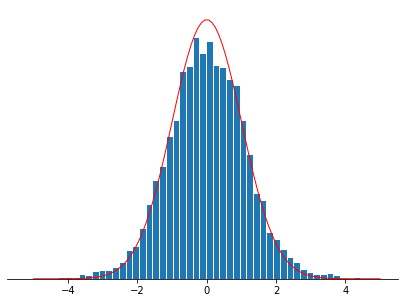

In [394]:
plt.figure(figsize=(7,5))
plt.hist(trans_t, bins=50, ec = 'w', density=True);
plt.plot(np.linspace(-5, 5, 100) , st.norm.pdf(np.linspace(-5, 5, 100)), lw = 1, color = 'r',)
f = plt.gca()
f.axes.get_yaxis().set_visible(False)
#plt.grid()
sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200410_prostrate_data.png")

In [8]:
gene10_control = prostrate.loc[(prostrate.gene == 10) & (prostrate.arm_type == 'control'), 'value']
gene10_cancer = prostrate.loc[(prostrate.gene == 10 )& (prostrate.arm_type == 'cancer'), 'value']

g10_control_mu, g10_control_svar = np.mean(gene10_control), np.var(gene10_control, ddof=1) / len(gene10_control)
g10_cancer_mu, g10_cancer_svar = np.mean(gene10_cancer), np.var(gene10_cancer, ddof=1) / len(gene10_cancer)

diff_se = np.sqrt(g10_control_svar + g10_cancer_svar)
diff_mu = g10_control_mu - g10_cancer_mu

In [9]:
st.t(df = 100, loc = 0, scale = diff_se).cdf(diff_mu) * 2

0.000820364421652602

In [10]:
p_val[10]

0.0008477232280075913

### Under Bonferroni

In [397]:
ttest_vals = np.array(list(ttest_res.values()))
z_vals = st.norm.ppf(st.t.cdf(ttest_vals, df = 100))
bonferroni_test = st.norm.ppf(0.05 / len(ttest_vals))
ttest_vals[z_vals < bonferroni_test], np.where(z_vals < bonferroni_test)


(array([-4.64325489, -5.64576222, -4.60622534, -5.10570942]),
 (array([ 331,  609,  913, 1719]),))

### Holm’s procedure 

In [398]:
sorted_order = np.argsort(z_vals)
sorted_order

array([ 609, 1719,  331, ..., 4545, 3939,  363])

In [399]:
i = np.arange(1, len(ttest_vals)+1)
p_vals = st.norm.cdf(z_vals)
sort_idx = np.argsort(p_vals)
mask = p_vals[sort_idx] > (0.05 / (len(p_vals) - i + 1))
min_pval = min(p_vals[sort_idx][mask])

ttest_vals[p_vals <= min_pval], np.where(p_vals <= min_pval)

(array([-4.64325489, -5.64576222, -4.60622534, -4.40374634, -5.10570942]),
 (array([ 331,  609,  913, 1067, 1719]),))

### Benjamini–Hochberg FDR Control

In [400]:
q = 0.05

mask = p_vals[sort_idx] <= ((i / len(p_vals)) * q)
max_pval = max(p_vals[sort_idx][mask])

ttest_vals[p_vals <= max_pval], p_vals[p_vals <= max_pval]

(array([-4.64325489, -4.34905939, -5.64576222, -4.60622534, -4.40374634,
        -4.1303678 , -4.31478357, -4.22225316, -3.82613758, -4.10219768,
        -5.10570942, -4.01281351, -4.31476232, -4.10309008]),
 array([5.22364520e-06, 1.64873569e-05, 7.72046120e-08, 6.05122735e-06,
        1.33602853e-05, 3.76244920e-05, 1.87952734e-05, 2.66863444e-05,
        1.13411720e-04, 4.17639174e-05, 7.88376505e-07, 5.79904041e-05,
        1.87967962e-05, 4.16263331e-05]))

In [489]:
np.sort(ttest_vals)[:10]

array([-5.64576222, -5.10570942, -4.64325489, -4.60622534, -4.40374634,
       -4.34905939, -4.31478357, -4.31476232, -4.22225316, -4.1303678 ])

In [449]:
np.argwhere(p_vals <= max_pval)

array([[ 331],
       [ 578],
       [ 609],
       [ 913],
       [1067],
       [1076],
       [1088],
       [1112],
       [1129],
       [1556],
       [1719],
       [3374],
       [3646],
       [4517]])

### Figure 15.3

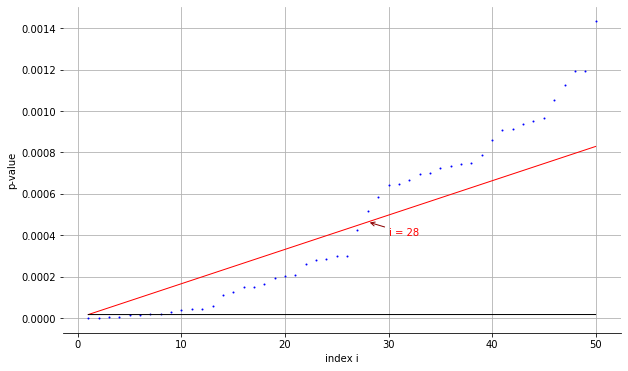

In [407]:
i = np.arange(1, 51)
plt.subplots(figsize = (10, 6))
plt.plot(i, p_vals[sort_idx][:50], ".b", ms=2)
plt.plot(i, i * 0.10 / len(p_vals), "r", lw=1)
plt.plot(i, 0.1 / (len(p_vals) - i + 1), 'k', lw = 1)
plt.annotate("i = 28", xy = (28, 28 * 0.10 / len(p_vals)), xytext  = (30, 24 * 0.10 / len(p_vals)), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='darkred'), color='r' )
plt.xlabel("index i")
plt.ylabel("p-value")

plt.grid()

sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200410_BH_FDR.png")

## Fully bayesian way

In [509]:
x1 = trans_t

In [510]:
with pm.Model() as m:
    
    sd = pm.HalfNormal('sd', 3)
    
    dist1 = pm.Normal.dist(0, 1)
    dist2 = pm.Normal.dist(0, sd)
    
    w = pm.Dirichlet('w', a= np.array([0.9, 0.1])) 
    like = pm.Mixture('like', w=w, comp_dists=[dist1, dist2], observed=x1)
    

INFO (theano.gof.compilelock): Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock


In [511]:
sample = pm.sample(model = m, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sd]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 460.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


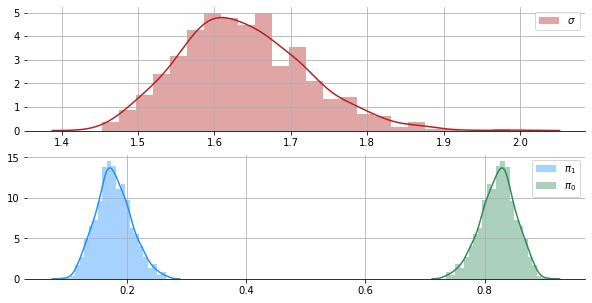

In [745]:
f, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.distplot(sample['sd'], ax=axes[0], color='firebrick', label = r'$\sigma$')
axes[0].legend()
axes[0].grid()
sns.distplot(sample['w'][:, 1], ax=axes[1], color='dodgerblue', label = r'$\pi_1$')
sns.distplot(sample['w'][:, 0], ax=axes[1], color='seagreen', label = r'$\pi_0$')
axes[1].legend()
axes[1].grid()
sns.despine(left = True)

plt.savefig("../../../../sidravi1.github.io/assets/20200412_posterior_dist.png")

In [705]:
pm.summary(sample)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd,1.63733,0.081728,0.004374,1.482677,1.793638,246.380899,0.999233
w__0,0.82292,0.029401,0.001708,0.768486,0.881537,221.073047,0.999433
w__1,0.17708,0.029401,0.001708,0.118463,0.231514,221.073047,0.999433


## Local fdr

In [706]:
f1 = st.norm(0, sample['sd']).pdf(x1.reshape(-1, 1))
f0 = st.norm(0, 1).pdf(x1.reshape(-1, 1))

In [707]:
f = (sample['w'][:, 0] * f0) + (sample['w'][:, 1] * f1)

In [709]:
f_ratio = sample['w'][:, 0] * f0/f

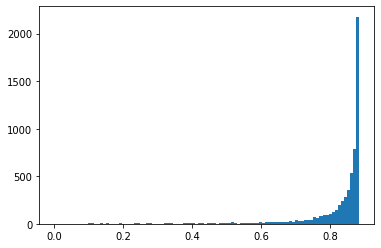

In [710]:
f_ratio_mean = f_ratio.mean(axis=1)
low, high = np.percentile(f_ratio, [2.5, 97.5], axis = 1)
plt.hist(f_ratio_mean, bins = 100);

In [711]:
np.argwhere(high <= 0.2).squeeze()

array([   1,  331,  363,  578,  609,  693,  697,  701,  720,  734,  738,
        904,  913,  920, 1067, 1076, 1088, 1112, 1129, 1313, 1345, 1556,
       1587, 1588, 1719, 2369, 2855, 2896, 2944, 3016, 3281, 3291, 3374,
       3599, 3646, 3664, 3929, 3939, 3990, 3999, 4072, 4087, 4103, 4315,
       4330, 4395, 4517, 4545, 4548, 4551, 4980])

## Bayesian Fdr

In [712]:
F1 = st.norm(0, sample['sd']).cdf(x1.reshape(-1, 1))
F0 = st.norm(0, 1).cdf(x1.reshape(-1, 1))

In [725]:
S = (sample['w'][:, 0] * (1 - F0)) + (sample['w'][:, 1] * (1 - F1))
S_ratio = (1 - F0) / S

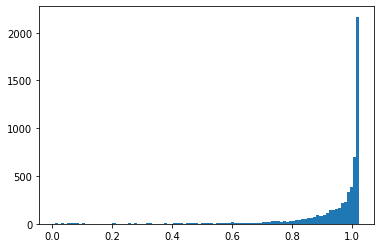

In [723]:
low, high = np.percentile(S_ratio, [2.5, 97.5], axis = 1)
plt.hist(S_ratio_mean, bins = 100);

In [733]:
significant_args = np.argwhere((high <= 0.1)).squeeze()

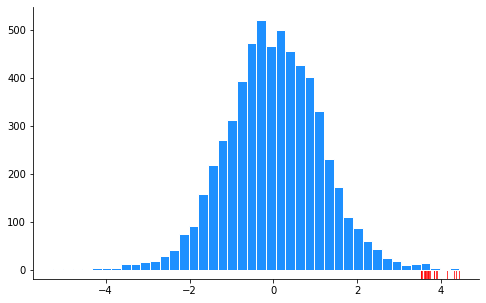

In [748]:
#vals, edges, _ = plt.hist(dti, bins=42, density=True, color ='dodgerblue', ec = 'k')
f = plt.figure(figsize= (8, 5))
gs = f.add_gridspec(30, 1)
gs.update(wspace=0.01, hspace=0.1) # set the spacing between axes. 
ax1 = f.add_subplot(gs[:29, :], )
ax1.hist(x1, bins=42, density=False, color ='dodgerblue', ec = 'w')
ax2 = f.add_subplot(gs[29, :], sharex = ax1)
ax2.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)

sns.rugplot(x1[significant_args], height = 1.5, ax=ax2, color='r', lw=0.5)
sns.rugplot(x1[significant_args], height = 1.5, ax=ax2, color='r', lw=0.5)
sns.despine(bottom = True, ax = ax1, )
sns.despine(ax = ax2)

plt.savefig("../../../../sidravi1.github.io/assets/20200412_bayesian_sig.png")

### Empirical Bayes Large-Scale Testing

In [16]:
from statsmodels.formula.api import glm
from patsy import dmatrix, balanced
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


$$
\hat{Fdr}(z_0) = \pi_0 S_0(z_0)/\hat{S}(z_0)
$$

In [17]:
def S0(z):
    return 1 - st.norm.cdf(z)

def Shat_z0_pos(z_vals, z0):
    return (z_vals.reshape(1, -1) > z0.reshape(-1, 1)).sum(axis = 1) / len(z_vals)

def Shat_z0_neg(z_vals, z0):
    return (z_vals.reshape(1, -1) < z0.reshape(-1, 1)).sum(axis = 1) / len(z_vals)


In [18]:
def FDR_hat(z0, z_vals, left=True, pi0 = 0.95):
    if left:
        return pi0 * S0(-z0) / Shat_z0_neg(z_vals, z0)
    else:
        return pi0 * S0(z0) / Shat_z0_pos(z_vals, z0)

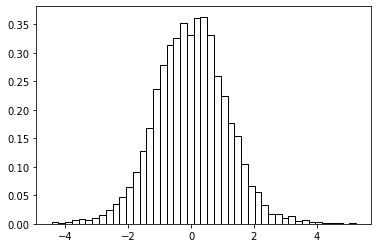

In [751]:
vals, edges, _ = nop.hist(-trans_t, bins=45, ec = 'k', color ='w', density=True)

In [754]:
vals, edges = np.histogram(-trans_t, bins=45, density=True)

In [755]:
mid_points = (edges[0:-1] + edges[1:]) / 2

In [756]:
X = PolynomialFeatures(degree=4).fit_transform(mid_points.reshape(-1, 1)) 
y = vals

m = sm.GLM(y, X, family=sm.families.Poisson(), ).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9.9953
Date:                Sun, 12 Apr 2020   Deviance:                     0.033609
Time:                        23:39:33   Pearson chi2:                   0.0341
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9883      0.606     -1.630      0.103      -2.176       0.200
x1             0.0061      0.597      0.010      0.992      -1.163       1.175
x2            -0.4733      0.428     -1.106      0.269      -1.312       0.365
x3            -0.0020      0.095     -0.021      0.983      -0.188       0.184
x4             0.0098      0.035      0.282      0.778      -0.058       0.078
==============================================================================
"""

In [757]:
y_hat = m.predict()

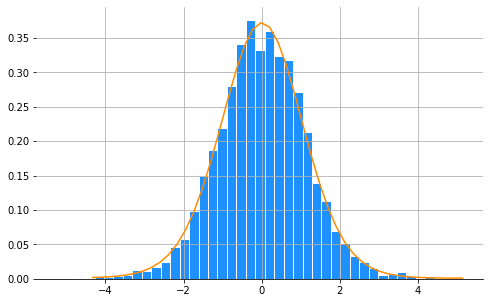

In [767]:
f = plt.figure(figsize= (8, 5))

vals, edges, _ = plt.hist(trans_t, bins=40, ec ='w', color='dodgerblue', density=True)
plt.plot(mid_points, y_hat, color='darkorange')
plt.grid()
sns.despine(left = True)

plt.savefig("../../../../sidravi1.github.io/assets/20200412_poisson_fitted.png")


In [24]:
def fhat(z, m):
    n_dims = m.params.shape[0]
    poly_vals = PolynomialFeatures(degree=(n_dims - 1)).fit_transform(z.reshape(-1, 1))
    
    return np.exp(poly_vals.squeeze() @ m.params)

def fdr_hat(z, m, pi0 = 0.9):
    return pi0 * st.norm.pdf(z) / fhat(z, m)

In [25]:
def fdr_hat(z, m, pi0 = 0.9):
    return pi0 * st.norm.pdf(z) / fhat(z, m)

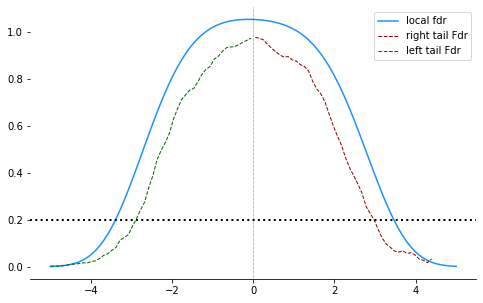

In [798]:
f = plt.figure(figsize= (8, 5))

pi0 = 0.984

z0 = np.linspace(-5, 5, 100)
z0_pos = z0[z0 >= 0]
z0_neg = z0[z0 <= 0]

plt.plot(z0, fdr_hat(z0, m, pi0 = pi0), color='dodgerblue', label = 'local fdr')

plt.plot(z0_pos, FDR_hat(z0_pos, z_vals, left=False, pi0 = pi0), "--", lw = 1, color='darkred', label ='right tail Fdr')
plt.plot(z0_neg, FDR_hat(z0_neg, z_vals, left=True, pi0 = pi0).squeeze(), "--", lw = 1, color='darkgreen', label ='left tail Fdr')
plt.axvline(x=0, ls = ":", lw= 0.5, color='k')
plt.axhline(y=0.2, ls = ":", lw= 2, color='k')
#plt.grid()
plt.legend()

sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200412_fdr_vs_FDR.png")

In [799]:
def fdr_bayes(sample, z):
    f1 = st.norm(0, sample['sd']).pdf(z.reshape(-1, 1))
    f0 = st.norm(0, 1).pdf(z.reshape(-1, 1))
    
    f = (sample['w'][:, 0] * f0) + (sample['w'][:, 1] * f1)
    
    return sample['w'][:, 0] * f0/

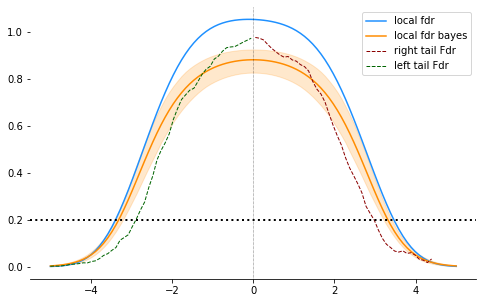

In [810]:
f = plt.figure(figsize= (8, 5))

pi0 = 0.984

z0 = np.linspace(-5, 5, 100)
z0_pos = z0[z0 >= 0]
z0_neg = z0[z0 <= 0]

plt.plot(z0, fdr_hat(z0, m, pi0 = pi0), color='dodgerblue', label = 'local fdr')

fdr_b = fdr_bayes(sample, z0)
mean_fdr_bayes = fdr_b.mean(axis=1)
low, high = np.percentile(fdr_b, [2.5, 97.5], axis = 1)

plt.plot(z0, mean_fdr_bayes, color='darkorange', label = 'local fdr bayes')
plt.fill_between(z0, low, high, color='darkorange', alpha = 0.2)

plt.plot(z0_pos, FDR_hat(z0_pos, z_vals, left=False, pi0 = pi0), "--", lw = 1, color='darkred', label ='right tail Fdr')
plt.plot(z0_neg, FDR_hat(z0_neg, z_vals, left=True, pi0 = pi0).squeeze(), "--", lw = 1, color='darkgreen', label ='left tail Fdr')
plt.axvline(x=0, ls = ":", lw= 0.5, color='k')
plt.axhline(y=0.2, ls = ":", lw= 2, color='k')
#plt.grid()
plt.legend()

sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200412_fdr_vs_FDR_vs_bayes.png")

In [ ]:
fdr_b = fdr_bayes(sample, z0)
mean_fdr_bayes = fdr_b.mean(axis=1)
low, high = np.percentile(fdr_b, [2.5, 97.5], axis = 1)

plt.plot(z0, mean_fdr_bayes, color='red', label = 'local fdr bayes')
plt.fill_between(z0, low, high, color='pink', label = 'local fdr bayes')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:                            GLM   Df Residuals:                       42
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -152.47
Date:                Thu, 19 Mar 2020   Deviance:                       57.109
Time:                        21:14:25   Pearson chi2:                     54.7
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1365      0.017    364.625      0.000       6.104       6.170
x1             0.0064      0.017      0.385      0.700      -0.026       0.039
x2            -0.4735      0.012    -39.835      0.000      -0.497      -0.450
x3            -0.0022      0.003     -0.829      0.407      -0.007       0.003
x4             0.0098      0.001     10.158      0.000       0.008       0.012
==============================================================================
"""

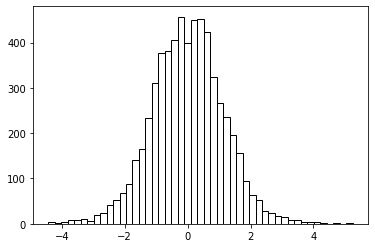

In [27]:
vals, edges, _ = plt.hist(-trans_t, bins=47, ec = 'k', color ='w')
mid_points = (edges[:-1] + edges[1:])/2

X = PolynomialFeatures(degree=4).fit_transform(mid_points.reshape(-1, 1)) 
y = vals

m = sm.GLM(y, X, family=sm.families.Poisson(), ).fit()
m.summary()

In [28]:
log_val = np.log(vals[vals > 0])

(-1, 7)

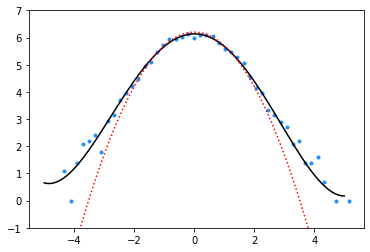

In [29]:
plt.plot(mid_points[vals > 0], log_val, ".", color='dodgerblue')
plt.plot(z0, np.log(fhat(z0, m)), "k")
plt.plot(z0, -0.5 * (z0**2) + 6.2, ":r")
plt.ylim(-1, 7)

## Null distribution through permutation

In [135]:
prostrate_permuted = prostrate.copy()
trans_t = []
for i in range(2):
    prostrate_permuted.arm_type = np.random.permutation(prostrate_permuted.arm_type)

    ttest_res = dict()
    p_val = dict()
    for gene, df in prostrate_permuted.groupby('gene'):
        ttest_res[gene], p_val[gene] = st.ttest_ind(df.loc[df.arm_type == 'control', 'value'], df.loc[df.arm_type == 'cancer', 'value'])

    trans_t.append(st.norm.ppf(st.t(df = 100).cdf(list(ttest_res.values()))))

In [136]:
st.norm.fit(np.array(trans_t).ravel())

(-0.010338934287814138, 1.0037896102739412)

### Using the police data

In [32]:
police = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/police.txt", header=None).values.squeeze()

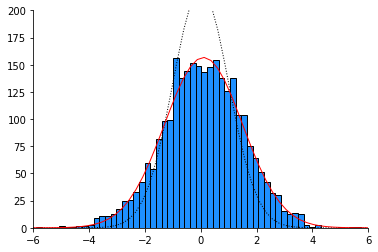

In [195]:
plt.hist(police, bins = 86, color='dodgerblue', ec='k')
plt.xlim(-6, 6)
plt.ylim(-0, 200)
x = np.linspace(-6, 6)
plt.plot(x, st.norm.pdf(x)*550, ':k', lw=1)
mu, sd = st.norm.fit(police)
plt.plot(x, st.norm(0.1, 1.4).pdf(x)*550, 'r', lw=1)
sns.despine()

# 15.6 Relevance

In [198]:
dti = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/DTI.txt").values.squeeze()

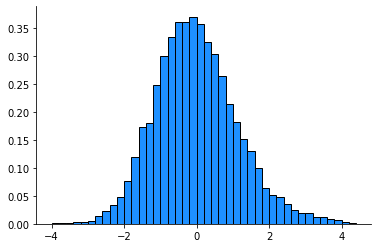

In [221]:
vals, edges, _ = plt.hist(dti, bins=42, density=True, color ='dodgerblue', ec = 'k')
mid_points = (edges[:-1] + edges[1:])/2
sns.despine()

In [249]:
for deg in range(3, 10):
    X = PolynomialFeatures(degree=deg).fit_transform(mid_points.reshape(-1, 1)) 
    y = vals

    m = sm.GLM(y, X, family=sm.families.Poisson(), ).fit()
    print(deg, m.resid_deviance.sum())

3 0.1019603420119841
4 0.03386212074400442
5 -0.014979303330644534
6 -0.009133052697130366
7 -0.01256867380674562
8 -0.010825714772651485
9 -0.010292243965352603


In [296]:
deg = 5

X = PolynomialFeatures(degree=deg).fit_transform(mid_points.reshape(-1, 1)) 
y = vals

m = sm.GLM(y, X, family=sm.families.Poisson(), ).fit()
y_hat = m.predict()

X_pred = PolynomialFeatures(degree=deg).fit_transform(dti.reshape(-1, 1)) 

fdr = 0.984 * st.norm(-0.12, 1.06).pdf(dti)/m.predict(X_pred)
fdr[fdr <= 0.2].shape, m.resid_deviance.sum()



In [309]:
zvals = np.linspace(-4, 4, 5000)
Xtest = PolynomialFeatures(degree=deg).fit_transform(zvals.reshape(-1, 1)) 
fdr_base = 0.984 * st.norm(-0.12, 1.06).pdf(zvals)/m.predict(Xtest)
zvals[fdr_base <= 0.2].min()

3.172634526905381

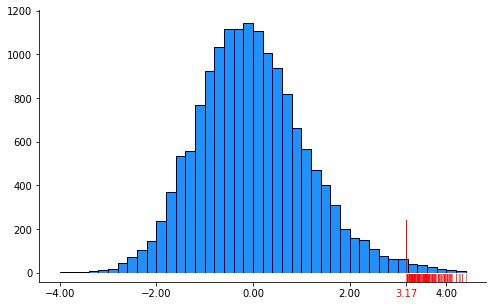

In [346]:
#vals, edges, _ = plt.hist(dti, bins=42, density=True, color ='dodgerblue', ec = 'k')
f = plt.figure(figsize= (8, 5))
gs = f.add_gridspec(30, 1)
gs.update(wspace=0.01, hspace=0.1) # set the spacing between axes. 
ax1 = f.add_subplot(gs[:29, :], )
ax1.hist(dti, bins=42, density=False, color ='dodgerblue', ec = 'k')
ax1.axvline(3.17, color='r', lw=1, ymax = 0.2)
ax2 = f.add_subplot(gs[29, :], sharex = ax1)
ax2.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
ax2.set_xticks(np.append(ax2.get_xticks(), 3.17))
ax2.get_xticklabels()[7].set_color("red")

sns.rugplot(dti[fdr <= 0.2], height = 1.5, ax=ax2, color='r', lw=0.5)
sns.despine(bottom = True, ax = ax1, )
sns.despine(ax = ax2)

In [33]:
police_central = police[(police > -1.8) & (police < 2.0)]

In [34]:
_ , _, mu, sd = st.truncnorm.fit(police_central)

In [35]:
#mu, sd = st.truncnorm(-1.8, 2).fit(police_central)
probs = st.norm(mu, sd).pdf(np.linspace(-4, 4))
mu, sd

(0.0024914441235413466, 1.123732933567277)

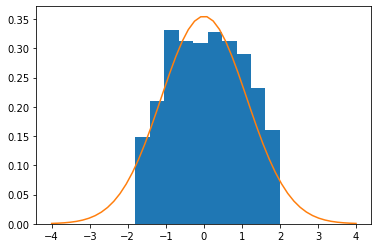

In [36]:
plt.hist(police_central, density=True)
plt.plot(np.linspace(-4, 4), probs)


In [88]:
from statsmodels.base.model import GenericLikelihoodModel

def logp(X, mu, sig, pi0, minZ, maxZ):
    
    N = X.shape[0]
    z0 = X[(X >= -minZ) & (X <= maxZ)]
    N0 = z0.shape[0]
    
    norm_dist = st.norm(mu, sig)
    P = norm_dist.cdf(maxZ) - norm_dist.cdf(minZ)
    
    theta = pi0 * P
    bin_ll = st.binom.logpmf(N0, N, theta)
    
    norm_dist = (norm_dist.logpdf(z0) - np.log(P)).sum()
    
    ll = bin_ll + norm_dist
    
    return ll

class Locfdr(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(Locfdr, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        mu = params[0]
        sig = np.exp(params[1])
        pi0 = params[2]
        minZ = np.exp(params[3])
        maxZ = np.exp(params[4])
        
        ll = logp(self.endog, mu, sig, pi0, minZ, maxZ)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        
        if start_params == None:
            # Reasonable starting values
            start_params = np.array([0, 2.0, 0.98, -2, 2])
        return super(Locfdr, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

In [125]:
def logp_pm(X):
    
    N = X.shape[0]
    z0 = X[(X >= -minZ) & (X <= maxZ)]
    N0 = z0.shape[0]
    
    norm_dist = pm.distributions.Normal.dist(mu, sig)
    P = tt.exp(norm_dist.logcdf(maxZ)) - tt.exp(norm_dist.logcdf(minZ))
    
    theta = pi0 * P
    bin_ll = pm.distributions.Binomial.dist(N, theta).logp(N0)
    
    norm_dist = (norm_dist.logp(z0) - tt.log(P)).sum()
    
    ll = bin_ll + norm_dist
    
    return ll

In [126]:
with pm.Model() as fdrLocal:
    mu = pm.Normal('mu', 0, 2)
    sig = pm.HalfNormal('sig', 1)
    pi0 = pm.Beta('pi0', 5, 1)
    
    minZ = pm.Uniform('minZ', np.min(police), 0)
    maxZ = pm.Uniform('maxZ', 0, np.max(police))
    
    obs = pm.DensityDist('obs', logp_pm, observed = police)
    
    

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [131]:
trace = pm.sample(500, tune=2000, model=fdrLocal, target_accept = 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [maxZ, minZ, pi0, sig, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [08:44<00:00, 19.06draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum

In [132]:
pm.summary(trace)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,3.852755,2.228938,0.222894,0.586008,6.853851,2.002002,241620.918979
sig,0.558169,0.371447,0.037145,0.108971,0.989025,2.002002,3113.490473
pi0,0.710945,0.411225,0.041123,0.000989,0.999556,2.002002,10472.590489
minZ,-3.566344,1.716595,0.171660,-5.971552,-1.143474,2.002003,1529.095342
maxZ,3.773872,1.895547,0.189555,1.157189,6.511518,2.002004,1240.466418


In [133]:
np.exp(100)

2.6881171418161356e+43

In [89]:
mod = Locfdr(police, np.ones_like(police))
res = mod.fit()

Optimization terminated successfully.
         Current function value: -2.417791
         Iterations: 478
         Function evaluations: 814


/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [90]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Locfdr Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                 6646.5
Model:                         Locfdr   AIC:                        -1.329e+04
Method:            Maximum Likelihood   BIC:                        -1.329e+04
Date:                Thu, 19 Mar 2020                                         
Time:                        22:14:07                                         
No. Observations:                2749                                         
Df Residuals:                    2748                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1245        nan        nan        nan         nan         nan
par0          -0.0896        nan        nan        nan         nan         nan
par1          43.4803        nan        nan        nan         nan         nan
par2           0.4606        nan        nan        nan         nan         nan
par3           0.4606        nan        nan        nan         nan         nan
==============================================================================
"""

In [87]:
np.exp(0.4), np.exp(2.11)

(1.4918246976412703, 8.24824128462666)

In [41]:
st.truncnorm(-1, 1, 2, 2z).pdf(0.5)

0.5157034505719386

In [43]:
st.norm(0, 1).pdf(0.5) / (st.norm.cdf(1) - st.norm.cdf(-1))

0.5157034505719386

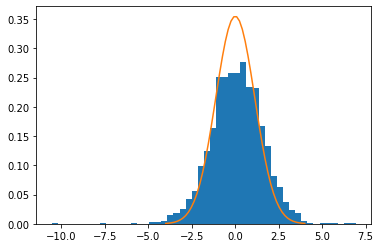

In [89]:
plt.hist(police, bins = 50, density=True);
plt.plot(np.linspace(-4, 4), probs)

In [ ]:
plt.hist(trans_t, bins=50, ec = 'k', color ='w', density=True);
plt.plot(np.linspace(-5, 5, 100) , st.norm.pdf(np.linspace(-5, 5, 100)), lw = 1, color = 'r',)